# WS01: Save the dike!

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:200px; height: auto; margin: 0" />
    <img src="https://github.com/TUDelft-CITG/HOS-prob-design-25/raw/main/assets/images/Logo.png" style="width:150px; height: auto; margin: 0" />
</h1>
<h2 style="height: 70px">
</h2>




*[CIEM42X0 Probabilistic Design](https://tudelft-citg.github.io/HOS-prob-design-25/): Week 1, Friday April 25th, 2025.*

## Introduction

In this assignment you are going to evaluate the safety of an existing dike whose main loading is the water level. To do so, you will analyze the different contributions of environmental variables to the loading and compute the probability of failure of the dike.

### Dike information

The crest elevation of the aforementioned dike is 8 m. As it is measured relative to the dike toe, the reference datum, the crest elevation is equivalent to the crest height:
$$
Z_{\mathrm{crest}}=h_{\mathrm{crest}}=8.0 \; \mathrm{m}
$$

### Loadings

The main loading is the water level which in this location is composed of: (1) still water level influenced by the tide ($Z_w$), (2) wave run up ($R_{u,2\%}$), and (3) wind setup ($S$). The water level is a random variable whose distribution is known (see below).

The **wave run up** ($R_{u,2\%}$) is computed as follows:

$$
Ru_{2\%} = 8 \cdot H_s \cdot \tan(\alpha)
$$

Where:
- $Ru_{2\%}$ [m] is the _vertical_ distance over which waves run up a slope after breaking, relative to the "still" water level
- $H_s$ [m] is the significant wave height
- $\alpha$ is the slope (can specify in degrees or radians as long as you use $\tan$ appropriately)

The **wind setup** ($S$) is computed as follows:

$$
S = C \cdot \frac{u^2}{g \cdot d} \cdot F
$$

Where:
- $S$ [m] is the _vertical_ increase in water level due to wind-induced setup at the toe of the dike, relative to the "still" water level
- $C$ [$-$] is a constant ($4\cdot 10^{-6}$)
- $u$ [m/s] is a representative wind speed
- $g$ is the gravitational constant
- $d$ [m] is the average water depth over the length of the inlet; we will use the value measured at the _entrance_ of the inlet (i.e., $d_{\mathrm{offshore}}$, see below)
- $F$ [m] is the distance over which the wind is acting

### Random Variables

For the case described above, four variables are considered random. There distributions are specified here, along with the location and scale parameters, using the format $\sim \mathrm{DIST}(loc,\,scale)$:

- Significant wave height [m], $Hs\sim\mathrm{Gumbel}(1, 0.2)$
- Wind speed [m/s], $u\sim\mathrm{Exp}(20, 1)$
- Water elevation [m], $Z_w\sim\mathrm{N}(4, 0.4)$
- Bottom elevation [m], $Z_b\sim\mathrm{N}(1, 0.1)$

Note that the location and scale parameters are _not_ the mean and standard deviation, but will make it much easier to specify these distributions using the appropriate `rv_continuous` sub-class from the `scipy.stats` package.

### Auxiliary functions

Three auxiliary functions are provided in an auxiliar file. Those functions compute the wind setup, the run up, and the water level at the toe of the dike. You can get familiar with them by opening the provided auxiliar file.

### Water depth, offshore

Here "offshore" refers to the conditions that are relatively far from the shore. Note that this water depth is needed to compute $S$.

$$
d_{\mathrm{offshore}}  = Z_w - Z_b
$$

Where:
- $Z$ denotes elevation relative to a datum such that the toe of the dike is $Z$=0 m (in other words: 0 m is not necessarily sea level!)
- $Z_w$ and $Z_b$ are elevations of the water surface and bottom level. They are considered random variables in order to take into account the tide and variability of bottom level, respectively.

As the bottom of the inlet has a variable elevation, this is an average depth.

**Water elevation/depth at the dike**

Because the setup is evaluated using offshore conditions, and we assume that the wave system does not change as it propagates through the inlet (ignore wind waves, damping, shoaling, breaking, etc.) the water depth at the dike can be approximated as a simple summation of the tidal level, 

$$
Z_d = Z_w + Ru_{2\%} + S
$$ 

Substituting each part from above gives the complete equation:

$$
Z_d
= Z_w
+ 8 H_s \tan(\alpha)
+ C \frac{u^2}{g (Z_w - Z_b)}F
$$

For our later tasks, note in particular the relationship of the four random variables:
- linearly proportional to $H_s$ and $u^2$
- non-linear relationship with $Z_w$ and $Z_b$


**Before starting** the assignment, here we import the auxiliary functions (it is assumed that the file is in the same folder as the present notebook) and some libraries. Feel free to add more of them if needed.

In [24]:
from auxiliary_functions import water_at_dike, wind_set_up, run_up_level
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Part 1: Functional response of the system (deterministic)

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1:</b>  
 
1. Identify the main physical processes that are at play in this problem, and get familiar with the equations available to describe them.
2. Write an equation (on paper) to define failure of the dike. You can use the code provided to check your answer.
3. Now that you have an equation, identify which random variables have a positive or negative effect on the performance of the dike.
4. Which environmental variable governs the dike design in this situation? Wave height or wind setup?
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution:</b>

1. The main physical processes are described above, as well as the equations. Note that we are using the wave run up exceeded by 2% of the incoming waves as representative of the run up (a statistic) but in reality each wave is different and thus generates a different wave run up level.</li>
2. As $Z_d$ increases, the dike becomes less safe; failure is assumed to happen when $Z_d>Z_{\mathrm{crest}}$. Thus, failure is defined by $Z_w + 8 H_s \tan(\alpha) + C \frac{u^2}{g (Z_w - Z_b)}F > 8$. </li>
3. The higher $Z_w$, $H_s$ and $u$, the higher $Z_d$ and, thus, the less safe the dike is. Similarly, the higher $Z_b$, the higher the generated $S$ as it decreases the value of the denominator and, thus, the less safe the dike. </li>
4. Although not illustrated here thoroughly, you can use the Python function below to change the values of the input variables and see which has the largest change on the output. A few observations are described here:
- Water surface ($Z_w$) elevation has the largest effect when making a 10% change in the absolute value
- Significant wave height ($H_s$) has the biggest infinitesimal impact on the water level height
- The sensitivity of wind speed ($u$) is _higher_ when the initial value of wind speed is higher (e.g., 30 m/s instead of 20 m/s)

The takeaways are:
- Because the units are different, it can be difficult to compare all variables in a consistent way;
- The "initial" values that you consider make an impact on the conclusion;
- Variability of the variables should also be taken into account, because it gives an idea for hwhat the likely range of change is for each one.</li>
</div>

In [6]:
def check_sensitivity(function, values, index, change, absolute_value=False):
    """
    Check sensitivity of a function to a change in one of its arguments.

    Parameters
    ----------
    function : function
        The function for which the sensitivity is to be checked
    values : list
        List of arguments to the function
    index : int
        Index of the argument to be changed
    change : float
        The amount by which the argument is to be changed
    absolute_value : bool, optional
        If True, the change is added to the argument.
        If False, the argument is multiplied by the change.
        Default is False.

    Returns
    -------
    None
    """

    start_value = (values[0],
                   values[1],
                   values[2],
                   values[3])

    if absolute_value:
        changes = [0, 0, 0, 0]
        changes[index] = change
        moved_value = (values[0] + changes[0],
                       values[1] + changes[1],
                       values[2] + changes[2],
                       values[3] + changes[3])
        print(f'Changing argument {index} by adding {change:.2f}')
    else:
        changes = [1., 1., 1., 1.]
        changes[index] = change
        moved_value = (values[0]*changes[0],
                       values[1]*changes[1],
                       values[2]*changes[2],
                       values[3]*changes[3])
        print(f'Changing argument {index} by {change:.1e} times')
        

    one = function(*start_value)
    two = function(*moved_value)

    print(f'--------------------------------------------------------')
    print(f'The starting value is {one:.3f}')
    print(f'The moved value is {two:.3f}')
    print(f'The calculated value has changed by {two - one:.2e}\n')


In [18]:
for i in range(4):
    check_sensitivity(water_at_dike, [1, 20, 4, 1], i, .1)

Changing argument 0 by 1.0e-01 times
--------------------------------------------------------
The starting value is 7.455
The moved value is 4.835
The calculated value has changed by -2.62e+00

Changing argument 1 by 1.0e-01 times
--------------------------------------------------------
The starting value is 7.455
The moved value is 6.917
The calculated value has changed by -5.38e-01

Changing argument 2 by 1.0e-01 times
--------------------------------------------------------
The starting value is 7.455
The moved value is 0.593
The calculated value has changed by -6.86e+00

Changing argument 3 by 1.0e-01 times
--------------------------------------------------------
The starting value is 7.455
The moved value is 7.330
The calculated value has changed by -1.25e-01



## Part 2: Uncertainty in the system

_Here is where you apply the [continuous parametric distributions](https://mude.citg.tudelft.nl/2024/book/probability/Reminder_intro.html) from MUDE!_

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2:</b>  
 
1. Define the distributions of each random variable using `scipy.stats` and get familiar with their characteristics
2. Which random variables have the most significant variability?
3. Identify how each random variable influences the equations defined in the deterministic part above.
4. Which random variable do you think will govern the dike design in this situation?
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
    <b>Solution:</b>
    
1. See code below.
2. See computations and summary table below. Note that for the non-Gaussian distributions the location and scale parameters are **not** the same thing as the mean and standard deviation! However, in this case, the numerical values are not that different. In the summary table, you have the coefficient of variation (c.o.v.) which is the quotient between the standard deviation and the mean of a random variable, giving a dimensionless metric of its variability. If we compare the c.o.v. of the different variables, we can see that the highest variability is that of the significant wave height. But does that mean it will have the biggest impact on the dike design? Not necessarily!
3. Recall from Part 1 that the random variables all combine to produce an effective water level at the dike. We can't tell from the distributions of the random variables themselves if the wind speed or the wave height would increase the effective water level observed at the dike more _given the probability distributions associated with them._ To understand that we need to somehow combine the likelihood of high values of these "load" variables along with the mechanical response of the dike (i.e., plug the values into the function from Part 1!). We will do this in Part 3.
4. Same as above.
</p>
</div>

In [17]:
# Define the distribution functions for each random variable

Hs = stats.gumbel_r(loc=1, scale=0.2) #significant wave height
u = stats.expon(loc=20, scale=1) #wind velocity
Zw = stats.norm(loc=4, scale=0.4) #water level
Zb = stats.norm(loc=1, scale=0.1) #bottom level

# Assess variability and show in a Table
all_dist_vars = ['Hs', 'u', 'Z_w', 'Z_bed']
all_dist = [Hs, u, Zw, Zb]
table = [['Variable', 'Dist', 'Mean', 'Std Dev', 'c.o.v.', 
          '5% value', '95% value', '99% value']]
for variable, dist in zip(all_dist_vars, all_dist):
    table.append([variable,
                  dist.dist.name,
                  '{:0.3f}'.format(dist.mean()),
                  '{:0.3f}'.format(dist.std()),
                  '{:0.3f}'.format(dist.std()/dist.mean()),
                  '{:0.3f}'.format(dist.ppf(0.05)),
                  '{:0.3f}'.format(dist.ppf(0.95)),
                  '{:0.3f}'.format(dist.ppf(0.99))])

for row in table:
    print(''.join([f'{item: <10}' for item in row]))


Variable  Dist      Mean      Std Dev   c.o.v.    5% value  95% value 99% value 
Hs        gumbel_r  1.115     0.257     0.230     0.781     1.594     1.920     
u         expon     21.000    1.000     0.048     20.051    22.996    24.605    
Z_w       norm      4.000     0.400     0.100     3.342     4.658     4.931     
Z_bed     norm      1.000     0.100     0.100     0.836     1.164     1.233     


## Part 3: Assessing the system

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3:</b>  
 
1. Using the Python functions provided, identify conditions where the dike (in its "current" form) is unsafe (using deterministic values only). Describe these critical conditions using a few values and figures.
2. Compute the probability that dike is unsafe. Does it meet the safety criteria (typically, a 1% probability of failure)?
   
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
    <b>Solution (part 1):</b>
    
We already have a function to quantify the demand, or "load," on the system: $Z_d$. The survival or "resistance" of the dike is the crest height, $Z_{crest}$, so we simply need to check whether the calculated load exceeds the capacity (the crest height).

The "Monte Carlo Simulation" part comes in because we would like to do this check for many realizations of the random variables (all the possible values and combinations), to estimate the failure probaiblity as the fraction of realizations where the dike has "failed." Since the random variables are assumed to be statistically independent (note that in reality $H_s$ and $u$ are usually not independent!), we can sample from each distribution separately, then plug the values into our function to obtain an empirical distribution of $Z_d$. Then the failure probability is simply $P[Z_d>Z_{\mathrm{crest}}]$.

This is illustrated in the code below.
</p>
</div>

In [20]:
n = 10000 #number of samples for the Montecarlo simulation

#Draw random samples from each defined distribution
Hs_samples = Hs.rvs(size = n) 
u_samples = u.rvs(size = n)
Zw_samples = Zw.rvs(size = n)
Zb_samples = Zb.rvs(size = n)

# Compute water depth offshore to compute the wind setup and the water level at the toe of the dike
d_offshore = Zw_samples - Zb_samples

# Compute water level at the toe of the dike
Zd_samples = water_at_dike(Hs_samples,
                           u_samples,
                           Zw_samples,
                           Zb_samples)

#Define the "resistance"
dike_height = 8

#Count the number of times that the dike crest height is exceeded and thus our structure "fails"
count = np.sum(Zd_samples > dike_height)
print(f'There are {count} samples greater than the dike height of {dike_height:0.2f} m ')
print(f'({count/n*100:0.2f}% of the samples).')

There are 3812 samples greater than the dike height of 8.00 m 
(38.12% of the samples).


<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
    <b>Solution (part 2):</b>
    
As we can see, the calculated probability far exceeds the allowable failure probability of 1%, so we must do something to improve this dike!

</p>
</div>

## Part 4: Designing a better system

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4:</b>  
 
1. Reconsider the deterministic and random variables and identify if and how each of them could be changed to improve the system. You should be able to think of explicit examples for what you can do in "real life" and explain the quantitative effect on each variable. For the random variables, you should explicitly consider whether you can influence one of three things: the mean, standard deviation or type of distribution. You should also explain whether a measure is practical. For example: _making the inlet more shallow by placing dredge spoils in it would reduce the mean value of water depth and would impact the runup height by ... ... ...; however, this is probably very expensive and not a very practical idea!_
2. Make a recommendation for how you can improve the system to meet the safety criteria. Explain the quantitative effect on the system (as described above) and provide quantitative confirmation that in these conditions the dike is safe.
   
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
    <b>Solution:</b>

There are many approaches to this, so you are encouraged to use the code yourself to explore various options. The main approach is to change the deterministic parameters and the location and scale of the random variables to see the quantitative effect on probability. Observations should include:
- you can have achieve big improvements by changing $u$ and $H_s$, however, since these are natural phenomenon, it is difficult to influence them. One practical measure could be installing something in the inlet to reduce wave heights.
- a similar observation can be made about the water and bottom elevations: these variables have an influence on the calculated probability, but are difficult to make changes in practice
- the most "obvious" or "practical" solutions would be to raise the dike or decrease the slope (this only impacts the wave runup). The choice for which one is selected would probably come down to the cost of materials (i.e., how does the cross-sectional area change?). To determine the needed crest height, we can plot the calculated distribution of the loading $Z_d$ and see what is the value associated with an exceedance probability of 1%. In the plot below, it can be seen that a crest level of approximately 10.2m would provide the required safety level. 
 
See code below as example of the computed options.

</p>
</div>

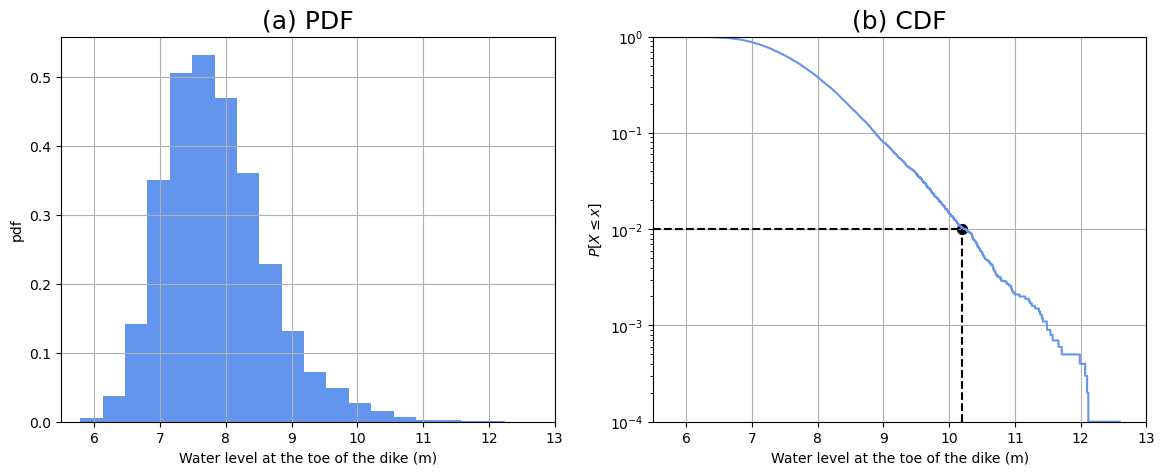

In [40]:
#Computing the required crest level

def ecdf(var):
    x = np.sort(var) # sort the values from small to large
    n = x.size # determine the number of datapoints\
    y = np.arange(1, n+1) / (n+1)
    return [y, x]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(Zd_samples, bins=20, density = True, color='cornflowerblue')
axes[0].set_xlabel('Water level at the toe of the dike (m)')
axes[0].set_ylabel('pdf')
axes[0].set_title('(a) PDF', fontsize=18)
axes[0].set_xlim([5.5, 13])
axes[0].grid()

axes[1].step(ecdf(Zd_samples)[1], 1-ecdf(Zd_samples)[0], 
             color='cornflowerblue')
axes[1].set_xlabel('Water level at the toe of the dike (m)')
axes[1].set_ylabel('${P[X \leq x]}$')
axes[1].set_title('(b) CDF', fontsize=18)
axes[1].set_xlim([5.5, 13])
axes[1].set_ylim([0.0001, 1])
axes[1].set_yscale('log')
axes[1].plot([5.5, 10.2], [0.01, 0.01], '--k')
axes[1].plot([10.2, 10.2], [0.0001, 0.01], '--k')
axes[1].scatter([10.2], [0.01], 50, c='k')
axes[1].grid()

In [42]:
#Assessing the influence of changing the distributions of the random variables: here we change the wave height distribution by reducing the location.

n = 10000 #number of samples for the Montecarlo simulation

#Draw random samples from each defined distribution
Hs_samples = stats.gumbel_r(loc=0.5, scale=0.2).rvs(size = n) 
u_samples = u.rvs(size = n)
Zw_samples = Zw.rvs(size = n)
Zb_samples = Zb.rvs(size = n)

# Compute water depth offshore to compute the wind setup and the water level at the toe of the dike
d_offshore = Zw_samples - Zb_samples

# Compute water level at the toe of the dike
Zd_samples = water_at_dike(Hs_samples,
                           u_samples,
                           Zw_samples,
                           Zb_samples)

#Define the "resistance"
dike_height = 8

#Count the number of times that the dike crest height is exceeded and thus our structure "fails"
count = np.sum(Zd_samples > dike_height)
print(f'There are {count} samples greater than the dike height of {dike_height:0.2f} m ')
print(f'({count/n*100:0.2f}% of the samples). Thus, we significantly reduce the probability of failure')

There are 446 samples greater than the dike height of 8.00 m 
(4.46% of the samples). Thus, we significantly reduce the probability of failure


End of the notebook.